### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 8


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант 18 
1. Набор данных dtd с изменением разрешения до 84x84 
2. Классы с метками 1,13,25,36 
3. Требования к архитектуре сети RNN: 
    - Последовательный API со списком слоев при создании 
    - Функция потерь: разреженная категориальная кросс-энтропия 
    - Слой LSTM с 96 нейронами 
    - Использование слоев пакетной нормализации 
4. Требования к архитектуре сети трансформер: 
    - Функция потерь: категориальная кросс-энтропия 
5. Показатель качества многоклассовой классификации: 
    - минимальная полнота классов, где полнота (recall) класса равна доле правильных предсказаний для всех точек, принадлежащих этому классу. 

# Выполнение

## 1. Загружаем датасет

In [1]:
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
ds_train, ds_test, ds_val = tfds.load("dtd", split=["train", "test", "validation"])
df_train = tfds.as_dataframe(ds_train)
df_test = tfds.as_dataframe(ds_test)
df_val = tfds.as_dataframe(ds_val)
print(len(df_train), len(df_test), len(df_val))
df_train.head()

2024-06-06 21:29:41.217069: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 21:29:41.220488: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 21:29:41.268550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 21:29:42.220569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-06 21:29:43.668220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-06 21:29:44.768732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

1880 1880 1880


,file_name,image,label
0,b'freckled/freckled_0117.jpg',"[[[215, 242, 249], [215, 242, 249], [216, 243,...",13
1,b'braided/braided_0108.jpg',"[[[32, 34, 23], [34, 36, 25], [38, 40, 29], [4...",2
2,b'flecked/flecked_0054.jpg',"[[[146, 143, 152], [143, 140, 149], [140, 137,...",12
3,b'crosshatched/crosshatched_0049.jpg',"[[[93, 64, 8], [85, 54, 0], [96, 62, 1], [104,...",8
4,b'polka-dotted/polka-dotted_0184.jpg',"[[[94, 108, 57], [115, 129, 78], [143, 157, 10...",30


In [3]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [4]:
rng_state = 1

In [5]:
def sample_images(n, random_state):
    for i in df_train.sample(n=n, random_state=random_state)["image"]:
        img = Image.fromarray(i)
        plt.figure()
        plt.imshow(img)

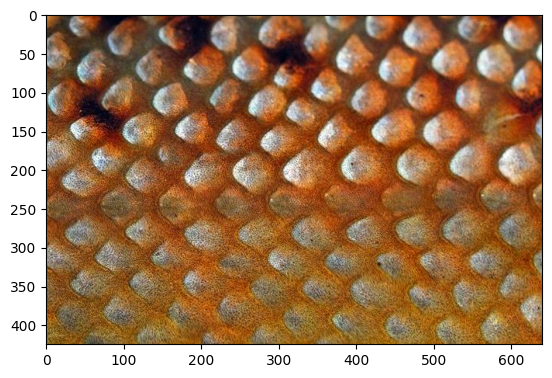

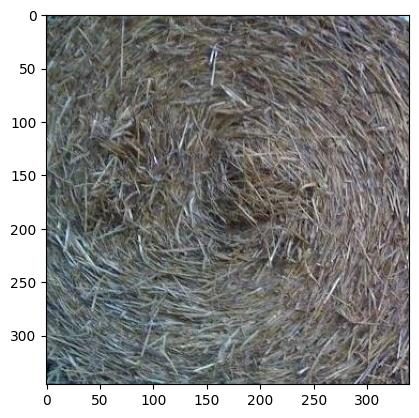

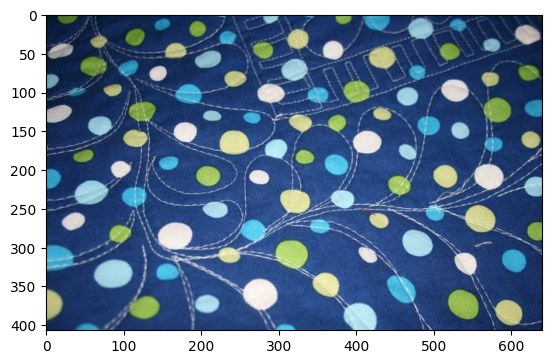

In [6]:
sample_images(3, rng_state)

### 1.1 Изменим размер изображений на 84x84

In [7]:
import numpy as np

In [8]:
WIDTH = 84
HEIGHT = 84

In [9]:
def resize(img):
    img = Image.fromarray(img)
    img = img.resize((WIDTH, HEIGHT))
    return np.asarray(img, np.uint8)

In [10]:
df_train["image"] = df_train["image"].map(resize)
df_test["image"] = df_test["image"].map(resize)
df_val["image"] = df_val["image"].map(resize)

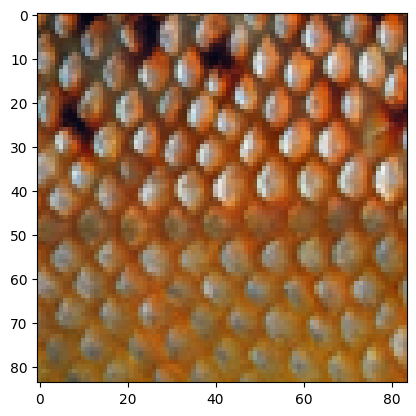

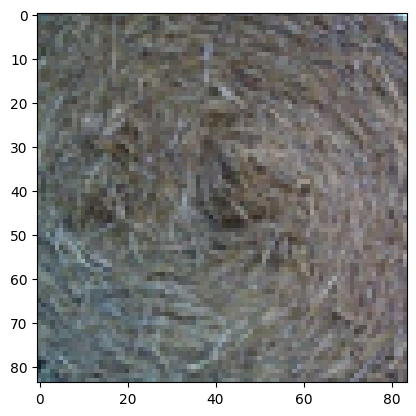

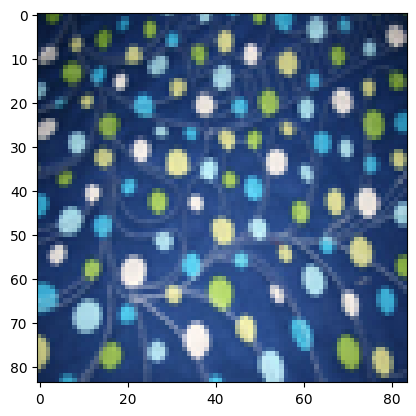

In [11]:
sample_images(3, rng_state)

## 2. Подготовка датасета

### 2.1 Оставляем только нужные классы

In [12]:
np.unique(np.asarray(df_train["label"]))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [13]:
CLASSES = [1, 13, 25, 36]
df_train = df_train[df_train["label"].isin(CLASSES)]
df_test = df_test[df_test["label"].isin(CLASSES)]
df_val = df_val[df_val["label"].isin(CLASSES)]
print(len(df_train), len(df_test), len(df_val))
df_train.head()

160 160 160


,file_name,image,label
0,b'freckled/freckled_0117.jpg',"[[[215, 242, 249], [213, 239, 243], [211, 234,...",13
6,b'blotchy/blotchy_0129.jpg',"[[[188, 91, 22], [186, 90, 21], [189, 91, 23],...",1
9,b'meshed/meshed_0112.jpg',"[[[176, 172, 180], [193, 192, 199], [174, 171,...",25
12,b'blotchy/blotchy_0048.jpg',"[[[58, 42, 19], [77, 58, 24], [64, 48, 20], [7...",1
25,b'freckled/freckled_0123.jpg',"[[[156, 121, 89], [176, 143, 110], [183, 154, ...",13


In [14]:
df_train[df_train["label"] == 1].sample(n=1)["file_name"].iloc[0]

b'blotchy/blotchy_0096.jpg'

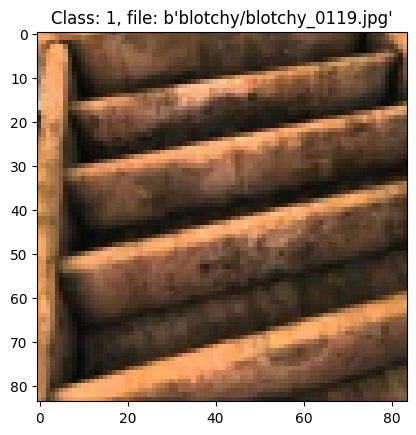

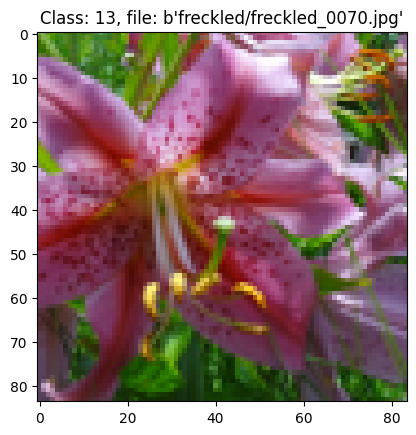

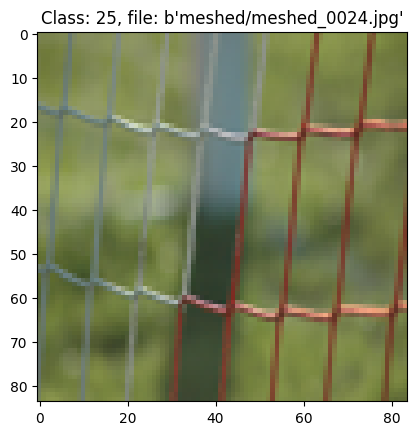

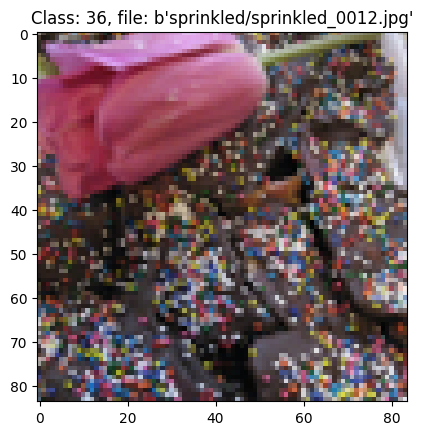

In [15]:
for cls in CLASSES:
    i = df_train[df_train["label"] == cls].sample(n=1, random_state=rng_state)
    img = i["image"].iloc[0]
    fname = i["file_name"].iloc[0]
    img = Image.fromarray(img)
    plt.figure()
    plt.title(f"Class: {cls}, file: {fname}")
    plt.imshow(img)

### 2.2 Подготовка данных для моделей

Меняем метки, чтобы они шли подряд от 0 до 3

In [16]:
CLS = list(range(len(CLASSES)))

In [17]:
df_train["label"] = df_train["label"].map(lambda x: CLS[CLASSES.index(x)])
df_test["label"] = df_test["label"].map(lambda x: CLS[CLASSES.index(x)])
df_val["label"] = df_val["label"].map(lambda x: CLS[CLASSES.index(x)])
print(len(df_train), len(df_test), len(df_val))
np.unique(np.asarray(df_train["label"]))

160 160 160


/tmp/ipykernel_845206/1663440719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["label"].map(lambda x: CLS[CLASSES.index(x)])
/tmp/ipykernel_845206/1663440719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = df_test["label"].map(lambda x: CLS[CLASSES.index(x)])
/tmp/ipykernel_845206/1663440719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

array([0, 1, 2, 3])

In [18]:
input_shape = df_train.iloc[0]["image"].shape
input_shape

(84, 84, 3)

In [19]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(pd.DataFrame(df_train, columns=["label"]), num_classes=len(CLASSES))
test_labels = to_categorical(pd.DataFrame(df_test, columns=["label"]), num_classes=len(CLASSES))
val_labels = to_categorical(pd.DataFrame(df_val, columns=["label"]), num_classes=len(CLASSES))
train_labels.shape, test_labels.shape, val_labels.shape

((160, 4), (160, 4), (160, 4))

In [20]:
train_images = np.zeros(shape=(df_train.shape[0],*input_shape), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],*input_shape), dtype=np.float32)
val_images  = np.zeros(shape=(df_val.shape[0],*input_shape), dtype=np.float32)

for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = df_train.iloc[idx]['image']

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = df_test.iloc[idx]['image']
    
for idx in range(val_labels.shape[0]):
    val_images[idx,:,:,:] = df_test.iloc[idx]['image']

train_images.shape, test_images.shape, val_images.shape

((160, 84, 84, 3), (160, 84, 84, 3), (160, 84, 84, 3))

## 3. Нейронные сети

In [21]:
import tensorflow as tf
from tensorflow.keras import *

In [22]:
early_stop_delay = 20
early_stop=callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=early_stop_delay,
    verbose=1
)

### 3.1 RNN

In [23]:
rnn = Sequential([
    layers.Input(shape=(input_shape)),
    # layers.Reshape((np.prod(input_shape[:2]), input_shape[-1])),
    layers.Reshape((input_shape[0], np.prod(input_shape[1:]))),
    # layers.Reshape((1, np.prod(input_shape))),
    layers.BatchNormalization(),
    layers.LSTM(128, activation="relu", return_sequences=True),
    layers.BatchNormalization(),
    layers.LSTM(96, activation="relu", return_sequences=False),
    layers.BatchNormalization(),
    layers.Dense(len(CLASSES), activation="softmax"),
], name="RNN")

rnn.summary()

rnn.compile(
    loss=losses.sparse_categorical_crossentropy,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

rnn_hist = rnn.fit(
    train_images,
    df_train["label"], # when using sparce cc labels should __not__ be one-hot
    epochs=100,
    batch_size=16,
    validation_data=(val_images, df_val["label"]),
    callbacks=[early_stop]
)

Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 84, 252)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 252)        │         1,008 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 84, 128)        │       195,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,764 (1.08 MB)

 Trainable params: 282,812 (1.08 MB)

 Non-trainable params: 952 (3.72 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.2390 - loss: 1.7968 - val_accuracy: 0.2750 - val_loss: 43556.0430
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.2387 - loss: 1.7786 - val_accuracy: 0.2812 - val_loss: 242.8439
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.3108 - loss: 1.7165 - val_accuracy: 0.2562 - val_loss: 189.6010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.2302 - loss: 1.6937 - val_accuracy: 0.2125 - val_loss: 91.5296
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2621 - loss: 1.8112 - val_accuracy: 0.2125 - val_loss: 21.8764
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2165 - loss: 1.7932 - val_accuracy: 0.2375 - val_loss: 56.5546
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.2482 - loss: 1.8166 - val_accuracy: 0.2812 - val_loss: 60.5301
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.3541 - loss: 1.5788 - val_accuracy

## 3.2 Transformer

Используем аугментацию данных:

In [24]:
def data_augmentation(image_size):
    data_augmentation = Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(train_images)
    return data_augmentation

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Создание патчей изображения в слое:

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


#### Реализация слоя кодирования патчей

In [27]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


#### Построение модели ViT

In [28]:
def create_vit_classifier(**params):
    inputs = Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(params["image_size"])(inputs)
    # Create patches.
    patches = Patches(params["patch_size"])(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(params["num_patches"], params["projection_dim"])(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(params["transformer_layers"]):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=params["num_heads"], key_dim=params["projection_dim"], dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=params["transformer_units"], dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=params["mlp_head_units"], dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits, name="ViT")
    return model

#### Создание, обучение и оценка модели

In [29]:
import os
from pathlib import Path
ch_path = Path(os.path.abspath("")) / "checkpoints"
os.makedirs(ch_path, exist_ok=True)

checkpoint_filepath = ch_path / "ViT_checkpoint.weights"
checkpoint_callback = callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [30]:
im_size = min(WIDTH, HEIGHT)
p_size = 6
proj_dim = 64
params = dict(
    learning_rate = 0.001,
    weight_decay = 0.0001,
    batch_size = 16,
    num_epochs = 100,
    image_size = im_size,
    patch_size = p_size,
    num_patches = (im_size // p_size) ** 2,
    projection_dim = proj_dim,
    num_heads = 4,
    transformer_units = [
        proj_dim * 4,
        proj_dim * 2,
        proj_dim,
    ],
    transformer_layers = 16,
    mlp_head_units = [
        2048,
        1024,
    ],
)

In [31]:
vit = create_vit_classifier(**params)

vit.summary()

optimizer = optimizers.AdamW(
    learning_rate=params["learning_rate"],
    weight_decay=params["weight_decay"]
)

vit.compile(
    optimizer=optimizer,
    loss=losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        metrics.CategoricalAccuracy(name="accuracy"),
        metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)

Model: "ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 84, 84, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 84, 84, 3) │          7 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 196, 108)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 64)   │     19,520 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 128)  │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 128)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 196, 64)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 29,804,747 (113.70 MB)

 Trainable params: 29,804,740 (113.70 MB)

 Non-trainable params: 7 (32.00 B)

In [32]:
vit_hist = vit.fit(
    train_images,
    train_labels,
    batch_size=params["batch_size"],
    epochs=params["num_epochs"],
    validation_data=(val_images, val_labels),
    callbacks=[checkpoint_callback, early_stop],
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.2249 - loss: 6.2730 - top-3-accuracy: 0.7139 - val_accuracy: 0.2812 - val_loss: 10.6324 - val_top-3-accuracy: 0.8375
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.2583 - loss: 11.9803 - top-3-accuracy: 0.7534 - val_accuracy: 0.2562 - val_loss: 8.1485 - val_top-3-accuracy: 0.7625
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.3609 - loss: 7.1619 - top-3-accuracy: 0.8465 - val_accuracy: 0.2812 - val_loss: 5.6018 - val_top-3-accuracy: 0.7750
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3431 - loss: 5.2335 - top-3-accuracy: 0.8323 - val_accuracy: 0.2750 - val_loss: 4.7430 - val_top-3-accuracy: 0.7750
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3094 - loss: 5.4362 - top-3-accuracy: 0.8077 - val_accuracy: 0.2750 - val_loss: 4.9505 - val_top-3-accuracy: 0.7812
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.3185 - loss: 5.6428 - top-3-accuracy: 0.

In [33]:
vit.load_weights(checkpoint_filepath)

In [34]:
vit.save(ch_path / "ViT.keras")

In [35]:
_, accuracy, top_3_accuracy = vit.evaluate(test_images, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 918ms/step - accuracy: 0.3049 - loss: 2.1453 - top-3-accuracy: 0.8037
Test accuracy: 30.0%


## 4. Матрицы ошибок

In [36]:
def from_one_hot(labels):
    return [np.where(x == 1) for x in labels]

In [37]:
for model in [vit, rnn]:
    print(model.name)
    train_pred = model.predict(train_images)
    train_pred = np.array([np.argmax(x) for x in train_pred])
    print("Confusion matrix for train data:")
    print(tf.math.confusion_matrix(df_train["label"], train_pred))
    test_pred = model.predict(test_images)
    test_pred = np.array([np.argmax(x) for x in test_pred])
    print("Confusion matrix for test data:")
    print(tf.math.confusion_matrix(df_test["label"], test_pred))
    print()

ViT
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 946ms/step
Confusion matrix for train data:
tf.Tensor(
[[25  2  3 10]
 [ 3 21  3 13]
 [18  1 11 10]
 [ 6  4  4 26]], shape=(4, 4), dtype=int32)
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 924ms/step
Confusion matrix for test data:
tf.Tensor(
[[21  3  2 14]
 [10  9  4 17]
 [19  1  4 16]
 [10  9  7 14]], shape=(4, 4), dtype=int32)

RNN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion matrix for train data:
tf.Tensor(
[[ 3  3 28  6]
 [ 3  0 26 11]
 [ 6  3 22  9]
 [ 7  0 21 12]], shape=(4, 4), dtype=int32)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion matrix for test data:
tf.Tensor(
[[ 4  1 27  8]
 [ 5  3 20 12]
 [ 3  2 22 13]
 [ 3  2 20 15]], shape=(4, 4), dtype=int32)



## 5. Визуализация кривых обучения

In [38]:
def scale_loss(losses): return np.asarray(losses) / losses[0]

In [39]:
import matplotlib.pyplot as plt

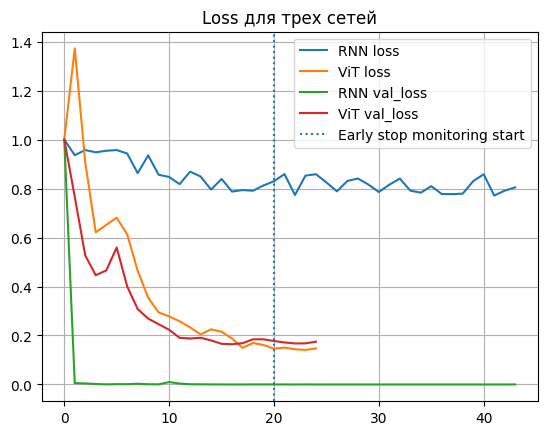

In [40]:
plt.figure()
plt.title("Loss для трех сетей")
plt.plot(scale_loss(rnn_hist.history["loss"]), label="RNN loss")
plt.plot(scale_loss(vit_hist.history["loss"]), label="ViT loss")
plt.plot(scale_loss(rnn_hist.history["val_loss"]), label="RNN val_loss")
plt.plot(scale_loss(vit_hist.history["val_loss"]), label="ViT val_loss")
plt.axvline(early_stop_delay, linestyle="dotted", label="Early stop monitoring start")
plt.legend()
plt.grid(True)

## 6. Оценка качества классификации

In [41]:
from sklearn.metrics import recall_score

best_model = None
best_score = float("-inf")

for model in [rnn, vit]:
    pred = model.predict(test_images)
    pred = np.array([[1 if prob > 0.5 else 0 for prob in x] for x in pred])
    score = recall_score(test_labels, pred, average="micro", zero_division=0)
    if score > best_score:
        best_score = score
        best_model = model
    print(f"Precision for model {model.name}: {score}")

print()
print("BEST MODEL:")
best_model.summary()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Precision for model RNN: 0.06875
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 934ms/step
Precision for model ViT: 0.40625

BEST MODEL:


Model: "ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 84, 84, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 84, 84, 3) │          7 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 196, 108)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 64)   │     19,520 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 128)  │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 128)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 196, 64)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 89,414,229 (341.09 MB)

 Trainable params: 29,804,740 (113.70 MB)

 Non-trainable params: 7 (32.00 B)

 Optimizer params: 59,609,482 (227.39 MB)